In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 6.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA

from lightgbm import LGBMRegressor
import shap
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
def preprocess(dfs):
    ret = []
    for df in dfs:
        df.set_index(df['time'], inplace=True)
        df.drop('time', axis=1, inplace=True)
        df = df.reindex(range(df.index[0], df.index[-1]+60000, 60000), method='pad')
        df.index = pd.to_datetime(df.index, unit='ms')
        ret.append(df)
    return ret

In [ ]:
btc = pd.read_csv('drive/MyDrive/diplom/btcusd.csv')
eth = pd.read_csv('drive/MyDrive/diplom/ethusd.csv')
sol = pd.read_csv('drive/MyDrive/diplom/solusd.csv')
solbtc = pd.read_csv('drive/MyDrive/diplom/solbtc.csv')

sol.drop('Unnamed: 0', axis=1, inplace=True)
solbtc.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
btc, eth, sol, solbtc = preprocess([btc, eth, sol, solbtc])
print('btc.shape: {}\teth.shape: {}\tsol.shape: {}\t solbtc.shape: {}'.format(btc.shape,
                                                                              eth.shape,
                                                                              sol.shape,
                                                                              solbtc.shape))

btc.shape: (4824559, 5)	eth.shape: (3278482, 5)	sol.shape: (666743, 5)	 solbtc.shape: (348387, 5)


In [ ]:
btc.rename(columns={'open': 'btc_open', 'close': 'btc_close',
                    'high': 'btc_high', 'low': 'btc_low', 'volume': 'btc_vol'}, inplace=True)
eth.rename(columns={'open': 'eth_open', 'close': 'eth_close',
                    'high': 'eth_high', 'low': 'eth_low', 'volume': 'eth_vol'}, inplace=True)
solbtc.rename(columns={'open': 'solbtc_open', 'close': 'solbtc_close',
                      'high': 'solbtc_high', 'low': 'solbtc_low', 'volume': 'solbtc_vol'}, inplace=True)

df = sol.merge(btc,
                left_index=True,
                right_index=True,
                how='left').merge(eth,
                                  left_index=True,
                                  right_index=True,
                                  how='left').merge(solbtc,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')

del btc, eth, sol, solbtc

df[['btc_open', 'btc_close', 'btc_high', 'btc_low', 'btc_vol',
    'eth_open', 'eth_close', 'eth_high', 'eth_low', 'eth_vol']] = df[['btc_open', 'btc_close', 'btc_high', 'btc_low', 'btc_vol',
    'eth_open', 'eth_close', 'eth_high', 'eth_low', 'eth_vol']].fillna(method='ffill')
df.fillna(-1.0, inplace=True)
df

,open,close,high,low,volume,btc_open,btc_close,btc_high,btc_low,btc_vol,eth_open,eth_close,eth_high,eth_low,eth_vol,solbtc_open,solbtc_close,solbtc_high,solbtc_low,solbtc_vol
time,,,,,,,,,,,,,,,,,,,,
2021-02-25 09:40:00,24.600,23.000,24.600,23.000,18.900000,49190.429711,49103.000000,49190.429711,49082.000000,12.048839,1596.7,1596.400000,1597.000000,1594.723536,63.871464,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-02-25 09:41:00,22.000,22.000,22.000,22.000,5.252031,49123.516960,49014.000000,49123.516960,49014.000000,3.869103,1596.4,1594.300000,1598.587819,1594.300000,68.120550,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-02-25 09:42:00,22.000,22.000,22.000,22.000,5.252031,49013.243524,48933.000000,49027.524041,48900.000000,23.043839,1595.0,1591.400000,1595.000000,1591.100000,7.558176,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-02-25 09:43:00,22.000,22.000,22.000,22.000,5.252031,48922.000000,48744.000000,48922.000000,48740.000000,21.125730,1590.4,1588.000000,1590.400000,1588.000000,1040.464185,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-02-25 09:44:00,22.000,22.000,22.000,22.000,5.252031,48758.000000,48828.678316,48922.157439,48673.000000,13.860813,1588.1,1593.174434,1593.900000,1588.000000,834.227122,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03 09:58:00,39.034,39.012,39.034,39.012,179.743399,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,1796.6,1797.500000,1798.000000,1796.300000,25.227200,0.001289,0.001289,0.001289,0.001289,0.001186
2022-06-03 09:59:00,39.032,39.032,39.032,39.032,0.439442,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,1796.6,1797.500000,1798.000000,1796.300000,25.227200,0.001289,0.001289,0.001289,0.001289,0.001186
2022-06-03 10:00:00,39.032,39.032,39.032,39.032,0.439442,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,1796.6,1797.500000,1798.000000,1796.300000,25.227200,0.001292,0.001292,0.001292,0.001292,0.001256


In [ ]:
df[df['solbtc_open'] > -1 ]

,open,close,high,low,volume,btc_open,btc_close,btc_high,btc_low,btc_vol,...,solbtc_vol_mean_14d,solbtc_vol_std_14d,solbtc_vol_mean_50d,solbtc_vol_std_50d,solbtc_vol_mean_100d,solbtc_vol_std_100d,ATH,ATL,RSI_ratio,target
time,,,,,,,,,,,,,,,,,,,,,
2021-10-04 11:50:00,165.770,165.810,165.910,165.770,1049.365197,47590.488430,47557.000000,47590.488430,47555.000000,1.387805,...,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,216.11,11.556,1.932957,-0.001811
2021-10-04 11:51:00,165.810,166.150,166.150,165.810,78.897230,47565.295703,47588.000000,47601.000000,47565.295703,6.113122,...,-0.999950,0.007108,-0.999986,0.003761,-0.999993,0.002660,216.11,11.556,1.642358,-0.001932
2021-10-04 11:52:00,166.130,166.000,166.130,166.000,9.872900,47588.865694,47581.000000,47591.000000,47581.000000,2.244539,...,-0.999900,0.010052,-0.999972,0.005319,-0.999986,0.003761,216.11,11.556,1.517369,0.000902
2021-10-04 11:53:00,166.270,166.440,166.440,166.270,9.917424,47592.000000,47625.000000,47625.000000,47591.000000,7.706396,...,-0.999850,0.012311,-0.999958,0.006515,-0.999979,0.004607,216.11,11.556,1.528134,0.000060
2021-10-04 11:54:00,166.380,166.330,166.380,166.250,1103.489800,47595.000000,47581.887854,47595.000000,47580.000000,4.100016,...,-0.999800,0.014215,-0.999944,0.007522,-0.999972,0.005319,216.11,11.556,1.391218,-0.000842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03 09:43:00,38.918,38.935,38.935,38.918,1.000000,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,...,6.272947,46.946967,5.358704,53.614883,4.193033,44.420905,259.80,11.556,1.114790,0.002412
2022-06-03 09:44:00,38.918,38.935,38.935,38.918,1.000000,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,...,6.275427,46.947956,5.359399,53.615137,4.193380,44.421068,259.80,11.556,0.539788,0.002925
2022-06-03 09:45:00,38.963,38.938,38.963,38.864,1355.757467,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,...,6.277907,46.948945,5.360093,53.615391,4.193708,44.421232,259.80,11.556,0.557339,0.001769


Text(0.5, 1.0, 'SOLBTC volume')

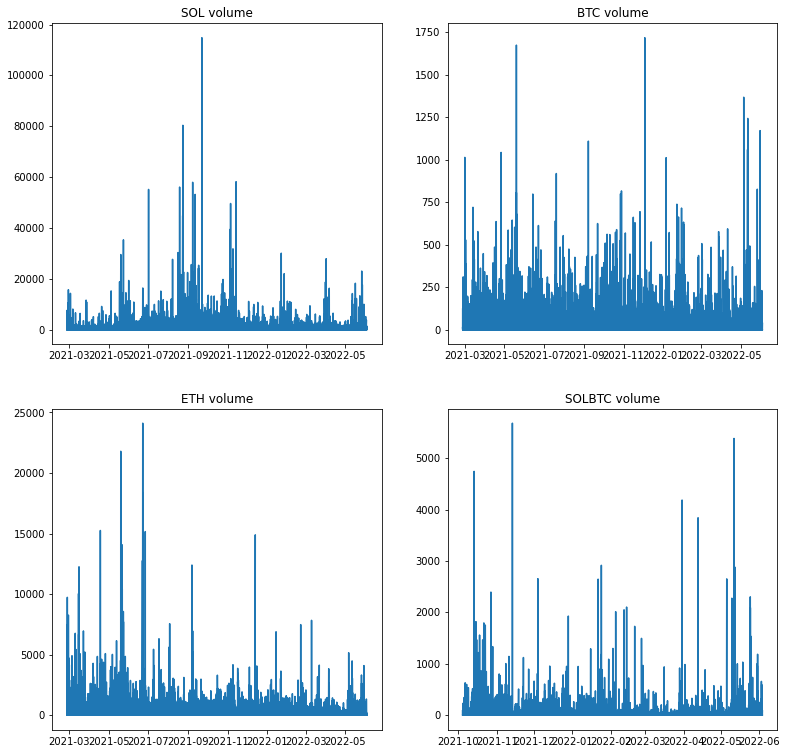

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13, 13))
ax1.plot(df.index, df['volume'])
ax1.set_title('SOL volume')


ax2.plot(df.index, df['btc_vol'])
ax2.set_title('BTC volume')


ax3.plot(df.index, df['eth_vol'])
ax3.set_title('ETH volume')


ax4.plot(df.loc['2021-10-04 11:50:00':].index, df.loc['2021-10-04 11:50:00':]['solbtc_vol'])
ax4.set_title('SOLBTC volume')

# FE

In [ ]:
# переменные по времени
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['hour'] = df.index.strftime('%H')
df['month'] = df.index.strftime('%m')
df['year'] = df.index.strftime('%Y')
df['is_night'] = df['hour'].apply(lambda x: 1 if int(x) in [0, 1, 2, 3, 4, 5, 22, 23] else 0 )
#df['1H'] = df.index.strftime('%Y-%m-%d %H')

df['hour'] = df['hour'].apply(int)
df['month'] = df['month'].apply(int)
df['year'] = df['year'].apply(int)

In [ ]:
lag_feats = ['open', 'volume', 'btc_open', 'btc_vol',
             'eth_open', 'eth_vol',
             'solbtc_open', 'solbtc_vol']

lag_windows = {60: '1h',
               60*24*1: '1d',
               60*24*14: '14d',
               60*24*50: '50d',
              60*24*100: '100d'}

for feat in tqdm(lag_feats):
    for window in lag_windows:
        df['{}_mean_{}'.format(feat, lag_windows[window])] = df[feat].rolling(window, min_periods=0).mean().shift(1)
        df['{}_std_{}'.format(feat, lag_windows[window])] = df[feat].rolling(window, min_periods=0).std().shift(1)

df.shape

100%|██████████| 8/8 [00:02<00:00,  3.77it/s]


(666743, 107)

In [ ]:
df['ATH'] = df['high'].cummax()
df['ATL'] = df['low'].cummin()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


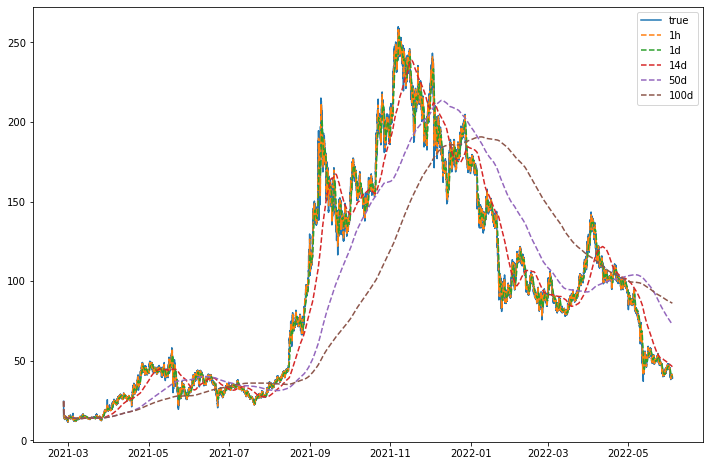

In [ ]:
# RSI
df['Diff'] = df['close'].transform(lambda x: x.diff())
df['Up'] = df['Diff']
df.loc[(df['Up']<0), 'Up'] = 0

df['Down'] = df['Diff']
df.loc[(df['Down']>0), 'Down'] = 0 
df['Down'] = abs(df['Down'])

df['avg_5up'] = df['Up'].transform(lambda x: x.rolling(window=5).mean())
df['avg_5down'] = df['Down'].transform(lambda x: x.rolling(window=5).mean())

df['avg_15up'] = df['Up'].transform(lambda x: x.rolling(window=15).mean())
df['avg_15down'] = df['Down'].transform(lambda x: x.rolling(window=15).mean())

df['RS_5'] = df['avg_5up'] / df['avg_5down']
df['RS_15'] = df['avg_15up'] / df['avg_15down']

df['RSI_5'] = 100 - (100/(1+df['RS_5']))
df['RSI_15'] = 100 - (100/(1+df['RS_15']))

df['RSI_ratio'] = df['RSI_5']/df['RSI_15']
df.drop(['Diff', 'Up', 'Down', 'avg_5up', 'avg_5down', 'avg_15up', 'avg_15down',
         'RS_5', 'RS_15', 'RSI_5', 'RSI_15'], axis=1, inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df.index, df['open'], label='true')
plt.plot(df.index, df['open_mean_1h'], '--', label='1h')
plt.plot(df.index, df['open_mean_1d'], '--', label='1d')
plt.plot(df.index, df['open_mean_14d'], '--', label='14d')
plt.plot(df.index, df['open_mean_50d'], '--', label='50d')
plt.plot(df.index, df['open_mean_100d'], '--', label='100d')

plt.legend();

In [ ]:
df.fillna(-1.0, inplace=True)
df['target'] = np.log(df['close'].shift(-15) / df['open'])
print(df.shape)
df.dropna(inplace=True)
df.shape

(666743, 111)


(666728, 111)

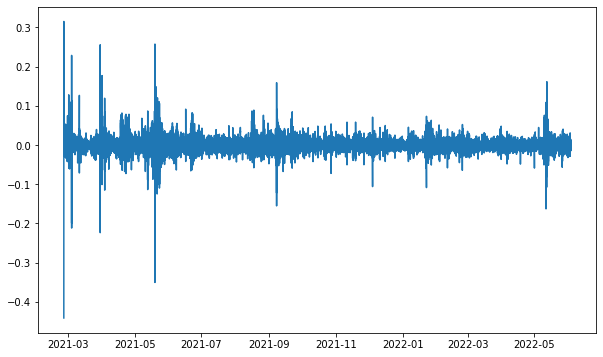

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['target']);

# 2. Train Test

In [ ]:
feat = ['day',
 'day_of_week',
 'day_of_year',
 'hour',
 'is_night',
 'open_mean_1h',
 'open_std_1h',
 'open_mean_1d',
 'open_std_1d',
 'open_mean_14d',
 'open_std_14d',
 'open_mean_50d',
 'open_std_50d',
 'open_mean_100d',
 'open_std_100d',
 'volume_mean_1h',
 'volume_std_1h',
 'volume_mean_1d',
 'volume_std_1d',
 'volume_mean_14d',
 'volume_std_14d',
 'volume_mean_50d',
 'volume_std_50d',
 'volume_mean_100d',
 'volume_std_100d',
 'btc_open_mean_1h',
 'btc_open_std_1h',
 'btc_open_mean_1d',
 'btc_open_std_1d',
 'btc_open_mean_14d',
 'btc_open_std_14d',
 'btc_open_mean_50d',
 'btc_open_std_50d',
 'btc_open_mean_100d',
 'btc_open_std_100d',
 'btc_vol_mean_1h',
 'btc_vol_std_1h',
 'btc_vol_mean_1d',
 'btc_vol_std_1d',
 'btc_vol_mean_14d',
 'btc_vol_std_14d',
 'btc_vol_mean_50d',
 'btc_vol_std_50d',
 'btc_vol_mean_100d',
 'btc_vol_std_100d',
 'eth_open_mean_1h',
 'eth_open_std_1h',
 'eth_open_mean_1d',
 'eth_open_std_1d',
 'eth_open_mean_14d',
 'eth_open_std_14d',
 'eth_open_mean_50d',
 'eth_open_std_50d',
 'eth_open_mean_100d',
 'eth_open_std_100d',
 'eth_vol_mean_1h',
 'eth_vol_std_1h',
 'eth_vol_mean_1d',
 'eth_vol_std_1d',
 'eth_vol_mean_14d',
 'eth_vol_std_14d',
 'eth_vol_mean_50d',
 'eth_vol_std_50d',
 'eth_vol_mean_100d',
 'eth_vol_std_100d',
 'solbtc_open_mean_1h',
 'solbtc_open_std_1h',
 'solbtc_open_mean_1d',
 'solbtc_open_std_1d',
 'solbtc_open_mean_14d',
 'solbtc_open_std_14d',
 'solbtc_open_mean_50d',
 'solbtc_open_std_50d',
 'solbtc_open_std_100d',
 'solbtc_vol_mean_1d',
 'solbtc_vol_std_1d',
 'solbtc_vol_mean_14d',
 'solbtc_vol_std_14d',
 'solbtc_vol_mean_50d',
 'solbtc_vol_std_50d',
 'solbtc_vol_mean_100d',
 'ATH',
 'ATL',
 'RSI_ratio']

In [ ]:
df_new = df.iloc[:, 20:].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)
#X_scaled = scaler.fit_transform(df_new.drop('target', axis=1))
#df_scaled = pd.DataFrame(columns=df_new.drop('target', axis=1).columns, data=X_scaled)
df_scaled = pd.DataFrame(columns=df_new.columns, data=df_scaled)
#df_scaled['target'] = df_new['target']

#pca = PCA(n_components=0.8)
#X_pca = pca.fit_transform(df_scaled.drop('target', axis=1))
#X_pca.shape, df_scaled.shape[1] - 1

In [ ]:
def inverse_transform_pca(data_reduced, pca):
    return np.dot(data_reduced, pca.components_) + pca.mean_
#inverse_transform_pca(X_pca, pca).shape

In [ ]:
X, y = df_scaled.drop('target', axis=1), df_scaled['target']
#X, y = X_pca, df_scaled['target']
X_train, X_test, y_train, y_test = train_test_split(X[feat], y, test_size=0.3, random_state=14, shuffle=False)
X_train.shape

(466709, 84)

In [ ]:
import tensorflow_probability as tfp
def MaxCorrelation(y_true,y_pred):
    """Goal is to maximize correlation between y_pred, y_true. Same as minimizing the negative."""
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return -tf.math.abs(tfp.stats.correlation(y_true_masked,y_pred_masked, sample_axis=None, event_axis=None))

def Correlation(y_true,y_pred):
    return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def masked_mse(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_mae(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

In [ ]:
window = 15
batch_size=1024
train_generator = TimeseriesGenerator(X_train, y_train.to_numpy(), length=window, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test.to_numpy(), length=window, batch_size=batch_size)

In [ ]:
print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: (1024, 15, 84)
Target shape: (1024,)


In [ ]:
lstm = keras.models.Sequential()
lstm.add(keras.Input(shape=(train_generator[0][0].shape[1], train_generator[0][0].shape[-1])))
lstm.add(layers.Bidirectional(layers.GRU(50, activation='gelu', return_sequences=True)))
lstm.add(layers.Dropout(0.2))
lstm.add(layers.GRU(25, activation=None, return_sequences=False))
lstm.add(layers.BatchNormalization())
lstm.add(layers.LeakyReLU())
lstm.add(layers.Dropout(0.2))
lstm.add(layers.Dense(1))

lstm.summary()

NameError: ignored

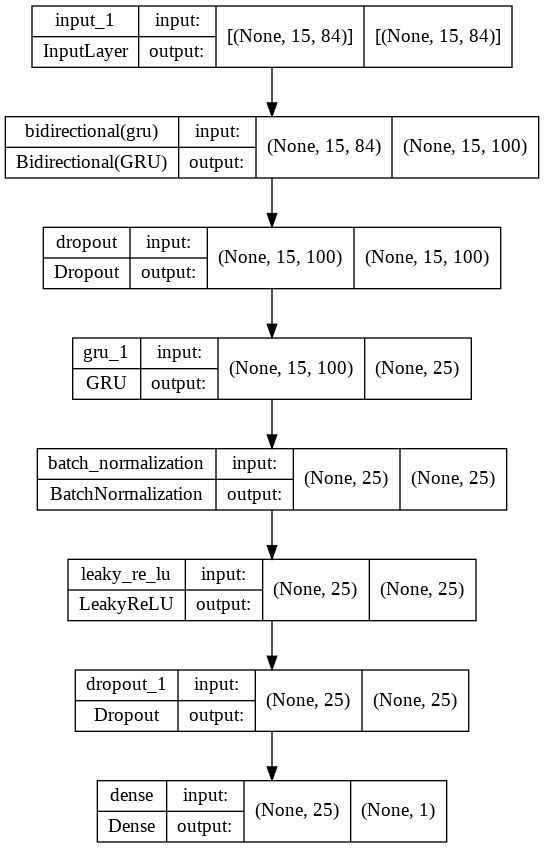

In [ ]:
tf.keras.utils.plot_model(lstm, show_shapes=True)

In [ ]:
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min',restore_best_weights=True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5*len(X_train)/1024), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
lstm.compile(optimizer='adam', loss=masked_cosine, metrics=[Correlation])

In [ ]:
from time import perf_counter, sleep

In [ ]:

start = perf_counter()
history = lstm.fit(train_generator, epochs=10, validation_data=(test_generator),
                             shuffle=False, callbacks=[lr, estop], workers=8, use_multiprocessing=True)
end = perf_counter()


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
456/456 [==============================] - 109s 225ms/step - loss: -0.0350 - Correlation: 0.0857 - val_loss: 0.0044 - val_Correlation: 0.1030 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009701423696242273.
Epoch 2/10
456/456 [==============================] - 103s 224ms/step - loss: -0.0659 - Correlation: 0.1067 - val_loss: 0.0132 - val_Correlation: 0.1063 - lr: 9.7014e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009411762584932148.
Epoch 3/10
456/456 [==============================] - 102s 220ms/step - loss: -0.0917 - Correlation: 0.1192 - val_loss: 0.0124 - val_Correlation: 0.1064 - lr: 9.4118e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009130749967880547.
Epoch 4/10
456/456 [==============================] - 104s 226ms/step - loss: -0.1199 - Correlation: 0.1377 - val_loss: 0.0124 - val_Correlation: 0.1077 - lr: 9.1307e-04

Epo

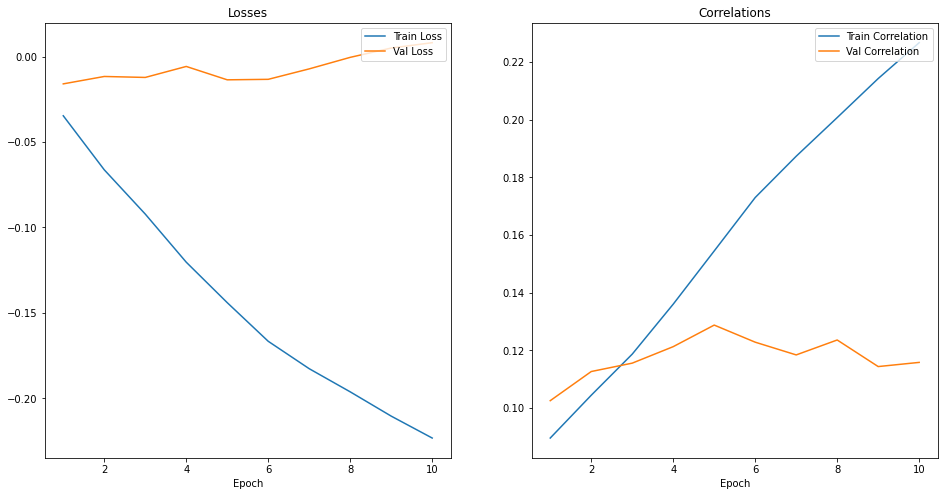

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

histories = pd.DataFrame(history.history)

epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']

ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

fig.show()

In [ ]:
predictions = lstm.predict(X_test.head(5))
predictions.shape

(5, 1)

In [ ]:
y_test[14:].shape

(200005,)

In [ ]:
np.corrcoef(predictions.ravel(), y_test[15:].to_numpy())[0,1]

0.005523659730562057

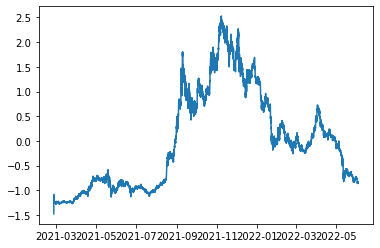

In [ ]:
plt.plot(df.index, df_scaled['open_mean_1h'])  

In [ ]:
df_scaled

,day,day_of_week,day_of_year,hour,month,year,is_night,open_mean_1h,open_std_1h,open_mean_1d,...,solbtc_vol_mean_14d,solbtc_vol_std_14d,solbtc_vol_mean_50d,solbtc_vol_std_50d,solbtc_vol_mean_100d,solbtc_vol_std_100d,ATH,ATL,RSI_ratio,target
0,1.043115,-0.000441,-1.108072,-0.361155,-1.221913,-0.703924,-0.7071,-1.479336,-3.148188,-1.479806,...,-0.705969,-0.886162,-0.831083,-0.990953,-0.908667,-1.034761,-1.438833,76.095585,-0.767432,-48.821653
1,1.043115,-0.000441,-1.108072,-0.361155,-1.221913,-0.703924,-0.7071,-1.083268,-3.148188,-1.083506,...,-0.705969,-0.886162,-0.831083,-0.990953,-0.908667,-1.034761,-1.438833,69.439482,-0.767432,-36.457605
2,1.043115,-0.000441,-1.108072,-0.361155,-1.221913,-0.703924,-0.7071,-1.103380,3.017749,-1.103631,...,-0.705969,-0.847026,-0.831083,-0.946925,-0.908667,-0.987446,-1.438833,69.439482,-0.767432,-36.457605
3,1.043115,-0.000441,-1.108072,-0.361155,-1.221913,-0.703924,-0.7071,-1.110085,2.284898,-1.110339,...,-0.705969,-0.847026,-0.831083,-0.946925,-0.908667,-0.987446,-1.438833,69.439482,-0.767432,-36.296871
4,1.043115,-0.000441,-1.108072,-0.361155,-1.221913,-0.703924,-0.7071,-1.113437,1.848031,-1.113693,...,-0.705969,-0.847026,-0.831083,-0.946925,-0.908667,-0.987446,-1.438833,69.439482,-0.767432,-36.296871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666723,-1.439440,0.500047,-0.125077,-0.361155,0.004230,1.420607,-0.7071,-0.852712,-0.443552,-0.835148,...,0.525281,0.990327,0.527505,1.413646,0.390999,1.114330,0.924230,-0.076866,0.063616,0.261038
666724,-1.439440,0.500047,-0.125077,-0.361155,0.004230,1.420607,-0.7071,-0.852939,-0.425822,-0.835157,...,0.525701,0.990366,0.527654,1.413657,0.391086,1.114338,0.924230,-0.076866,-0.162342,0.317768
666725,-1.439440,0.500047,-0.125077,-0.361155,0.004230,1.420607,-0.7071,-0.853146,-0.407283,-0.835166,...,0.526121,0.990404,0.527802,1.413669,0.391168,1.114346,0.924230,-0.076866,-0.155445,0.189858
666726,-1.439440,0.500047,-0.125077,-0.361155,0.004230,1.420607,-0.7071,-0.853321,-0.391637,-0.835174,...,0.526121,0.990404,0.527802,1.413669,0.391168,1.114346,0.924230,-0.076866,0.065965,0.081961


In [ ]:
X_test

,day,day_of_week,day_of_year,hour,is_night,open_mean_1h,open_std_1h,open_mean_1d,open_std_1d,open_mean_14d,...,solbtc_vol_mean_1d,solbtc_vol_std_1d,solbtc_vol_mean_14d,solbtc_vol_std_14d,solbtc_vol_mean_50d,solbtc_vol_std_50d,solbtc_vol_mean_100d,ATH,ATL,RSI_ratio
466709,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.797532,-0.108566,0.797912,-0.535400,0.911968,...,0.103337,-0.223246,0.511324,0.216817,0.802527,0.530032,2.120148,0.92423,-0.076866,0.351020
466710,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.797715,-0.127559,0.797952,-0.537495,0.911948,...,0.103337,-0.223246,0.511188,0.216815,0.802401,0.530021,2.120148,0.92423,-0.076866,0.351020
466711,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.797898,-0.147797,0.797993,-0.539600,0.911929,...,0.102953,-0.223228,0.511052,0.216813,0.802276,0.530010,2.120148,0.92423,-0.076866,0.351020
466712,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.798112,-0.178139,0.798030,-0.541320,0.911909,...,0.102569,-0.223210,0.510915,0.216810,0.802150,0.529999,2.120148,0.92423,-0.076866,0.397688
466713,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.798326,-0.210881,0.798066,-0.543017,0.911889,...,0.102185,-0.223191,0.510779,0.216808,0.802025,0.529987,2.120148,0.92423,-0.076866,-0.374462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666723,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.852712,-0.443552,-0.835148,-0.888944,-0.745876,...,0.409030,0.707214,0.525281,0.990327,0.527505,1.413646,0.390999,0.92423,-0.076866,0.063616
666724,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.852939,-0.425822,-0.835157,-0.888089,-0.745887,...,0.413810,0.707812,0.525701,0.990366,0.527654,1.413657,0.391086,0.92423,-0.076866,-0.162342
666725,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.853146,-0.407283,-0.835166,-0.887211,-0.745898,...,0.418590,0.708409,0.526121,0.990404,0.527802,1.413669,0.391168,0.92423,-0.076866,-0.155445
666726,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.853321,-0.391637,-0.835174,-0.886400,-0.745908,...,0.418590,0.708409,0.526121,0.990404,0.527802,1.413669,0.391168,0.92423,-0.076866,0.065965


In [ ]:
df_pred = df_scaled[466709	+ 15:].copy()
df_pred['target'] = predictions.ravel()
df_pred = pd.DataFrame(columns=df_pred.columns, data=scaler.inverse_transform(df_pred))
df_pred

,day,day_of_week,day_of_year,hour,month,year,is_night,open_mean_1h,open_std_1h,open_mean_1d,...,solbtc_vol_mean_14d,solbtc_vol_std_14d,solbtc_vol_mean_50d,solbtc_vol_std_50d,solbtc_vol_mean_100d,solbtc_vol_std_100d,ATH,ATL,RSI_ratio,target
0,15.0,5.0,15.0,12.0,1.0,2022.0,0.0,146.288500,0.252753,146.167500,...,6.184493,27.182495,6.640284,33.540949,11.088707,52.700311,259.8,11.556,-1.000000,0.026786
1,15.0,5.0,15.0,12.0,1.0,2022.0,0.0,146.291167,0.249515,146.169069,...,6.183997,27.182517,6.640283,33.540950,11.088690,52.700315,259.8,11.556,-1.000000,0.028213
2,15.0,5.0,15.0,12.0,1.0,2022.0,0.0,146.293833,0.246206,146.170708,...,6.183501,27.182539,6.640281,33.540950,11.088672,52.700318,259.8,11.556,0.000000,0.029479
3,15.0,5.0,15.0,12.0,1.0,2022.0,0.0,146.295167,0.244301,146.172292,...,6.183017,27.182558,6.640284,33.540949,11.088656,52.700321,259.8,11.556,0.000000,0.029996
4,15.0,5.0,15.0,12.0,1.0,2022.0,0.0,146.296500,0.242374,146.173986,...,6.182533,27.182576,6.640286,33.540949,11.088640,52.700324,259.8,11.556,0.000000,0.030541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199999,3.0,4.0,154.0,9.0,6.0,2022.0,0.0,39.502033,0.245074,40.643323,...,6.272947,46.946967,5.358704,53.614883,4.193033,44.420905,259.8,11.556,1.114790,0.433491
200000,3.0,4.0,154.0,9.0,6.0,2022.0,0.0,39.487350,0.253236,40.642766,...,6.275427,46.947956,5.359399,53.615137,4.193380,44.421068,259.8,11.556,0.539788,0.433148
200001,3.0,4.0,154.0,9.0,6.0,2022.0,0.0,39.473983,0.261770,40.642183,...,6.277907,46.948945,5.360093,53.615391,4.193708,44.421232,259.8,11.556,0.557339,0.433682
200002,3.0,4.0,154.0,9.0,6.0,2022.0,0.0,39.462683,0.268973,40.641632,...,6.277907,46.948945,5.360093,53.615391,4.193708,44.421232,259.8,11.556,1.120768,0.434121


In [ ]:
df[466709	+ 15:]

,open,close,high,low,volume,btc_open,btc_close,btc_high,btc_low,btc_vol,...,solbtc_vol_mean_14d,solbtc_vol_std_14d,solbtc_vol_mean_50d,solbtc_vol_std_50d,solbtc_vol_mean_100d,solbtc_vol_std_100d,ATH,ATL,RSI_ratio,target
time,,,,,,,,,,,,,,,,,,,,,
2022-01-15 12:24:00,146.070,146.070,146.070,146.070,1.010000,43017.000000,43011.000000,43018.000000,43010.000000,0.569341,...,6.184493,27.182495,6.640284,33.540949,11.088707,52.700311,259.8,11.556,-1.000000,-0.007835
2022-01-15 12:25:00,146.070,146.070,146.070,146.070,1.010000,43013.000000,42996.122852,43016.000000,42991.000000,0.804151,...,6.183997,27.182517,6.640283,33.540950,11.088690,52.700315,259.8,11.556,-1.000000,-0.010184
2022-01-15 12:26:00,145.990,145.990,145.990,145.990,0.293388,42996.122852,42972.527128,43000.000000,42972.527128,1.961221,...,6.183501,27.182539,6.640281,33.540950,11.088672,52.700318,259.8,11.556,0.000000,-0.008323
2022-01-15 12:27:00,145.990,145.990,145.990,145.990,0.293388,42975.951961,42958.000000,42975.951961,42952.000000,0.537482,...,6.183017,27.182558,6.640284,33.540949,11.088656,52.700321,259.8,11.556,0.000000,-0.011505
2022-01-15 12:28:00,145.990,145.990,145.990,145.990,0.293388,42962.000000,42939.000000,42962.000000,42939.000000,0.594976,...,6.182533,27.182576,6.640286,33.540949,11.088640,52.700324,259.8,11.556,0.000000,-0.012129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03 09:43:00,38.918,38.935,38.935,38.918,1.000000,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,...,6.272947,46.946967,5.358704,53.614883,4.193033,44.420905,259.8,11.556,1.114790,0.002412
2022-06-03 09:44:00,38.918,38.935,38.935,38.918,1.000000,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,...,6.275427,46.947956,5.359399,53.615137,4.193380,44.421068,259.8,11.556,0.539788,0.002925
2022-06-03 09:45:00,38.963,38.938,38.963,38.864,1355.757467,30204.200135,30225.706206,30225.706206,30204.200135,0.015000,...,6.277907,46.948945,5.360093,53.615391,4.193708,44.421232,259.8,11.556,0.557339,0.001769


In [ ]:
X_test

,day,day_of_week,day_of_year,hour,is_night,open_mean_1h,open_std_1h,open_mean_1d,open_std_1d,open_mean_14d,...,solbtc_vol_mean_1d,solbtc_vol_std_1d,solbtc_vol_mean_14d,solbtc_vol_std_14d,solbtc_vol_mean_50d,solbtc_vol_std_50d,solbtc_vol_mean_100d,ATH,ATL,RSI_ratio
466709,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.797532,-0.108566,0.797912,-0.535400,0.911968,...,0.103337,-0.223246,0.511324,0.216817,0.802527,0.530032,2.120148,0.92423,-0.076866,0.351020
466710,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.797715,-0.127559,0.797952,-0.537495,0.911948,...,0.103337,-0.223246,0.511188,0.216815,0.802401,0.530021,2.120148,0.92423,-0.076866,0.351020
466711,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.797898,-0.147797,0.797993,-0.539600,0.911929,...,0.102953,-0.223228,0.511052,0.216813,0.802276,0.530010,2.120148,0.92423,-0.076866,0.351020
466712,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.798112,-0.178139,0.798030,-0.541320,0.911909,...,0.102569,-0.223210,0.510915,0.216810,0.802150,0.529999,2.120148,0.92423,-0.076866,0.397688
466713,-0.085319,1.000536,-1.519325,0.072236,-0.7071,0.798326,-0.210881,0.798066,-0.543017,0.911889,...,0.102185,-0.223191,0.510779,0.216808,0.802025,0.529987,2.120148,0.92423,-0.076866,-0.374462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666723,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.852712,-0.443552,-0.835148,-0.888944,-0.745876,...,0.409030,0.707214,0.525281,0.990327,0.527505,1.413646,0.390999,0.92423,-0.076866,0.063616
666724,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.852939,-0.425822,-0.835157,-0.888089,-0.745887,...,0.413810,0.707812,0.525701,0.990366,0.527654,1.413657,0.391086,0.92423,-0.076866,-0.162342
666725,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.853146,-0.407283,-0.835166,-0.887211,-0.745898,...,0.418590,0.708409,0.526121,0.990404,0.527802,1.413669,0.391168,0.92423,-0.076866,-0.155445
666726,-1.439440,0.500047,-0.125077,-0.361155,-0.7071,-0.853321,-0.391637,-0.835174,-0.886400,-0.745908,...,0.418590,0.708409,0.526121,0.990404,0.527802,1.413669,0.391168,0.92423,-0.076866,0.065965


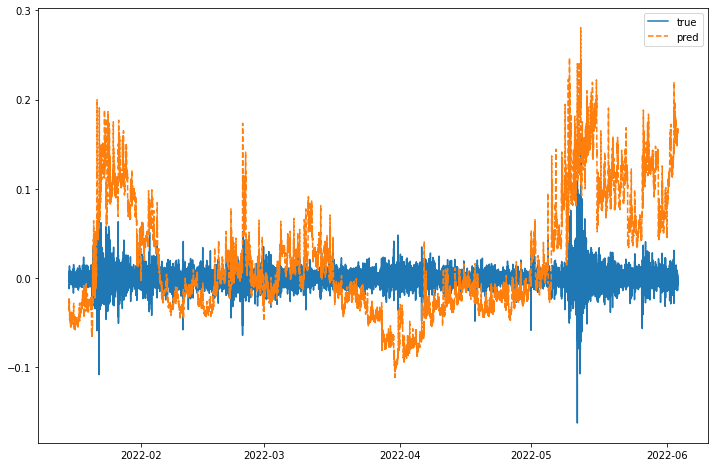

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df[466709	+ 15:].index, df[466709	+ 15:]['target'], label='true')
plt.plot(df[466709	+ 15:].index, df_pred['target'] / 2 - 0.05, '--', label='pred')
plt.legend();

In [ ]:
df_pred['target'].max()

0.6611977766578065

In [ ]:
(end-start)/60

0.027939616233334165

In [ ]:
stats = pd.DataFrame(columns=['model_name', 'model_type',
                     'data_norm', 'train_time',
                     'train_cos_dist', 'train_corr',
                     'test_cos_dist', 'test_corr'])
d = {}
d['model_name'] = 'BGRU'
d['model_type'] = 'GRU'
d['data_norm'] = 1
d['train_time'] = (end - start) / 60
d['train_cos_dist'] = -0.2212 
d['train_corr'] = 0.2238  
d['test_cos_dist'] = 9.1233e-05
d['test_corr'] = 0.1142 

stats = stats.append(d, ignore_index=True)
stats

,model_name,model_type,data_norm,train_time,train_cos_dist,train_corr,test_cos_dist,test_corr
0,BGRU,GRU,1,18.247179,-0.2212,0.2238,0.000091,0.1142


In [ ]:
stats.to_csv('bgru.csv')

SHAP

In [ ]:
explainer = shap.GradientExplainer(lstm, X_train.head(100000).to_numpy())


In [ ]:
shap_values = explainer.shap_values(X_test.head(15000).values )

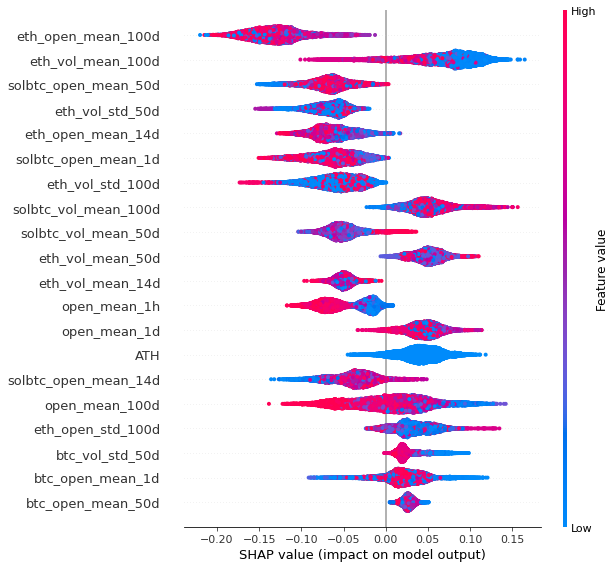

In [ ]:
shap.summary_plot(shap_values[0], X_test.head(15000), feature_names=X_train.columns)